<a href="https://colab.research.google.com/github/Mjcherono/Deployment-Resources./blob/main/Model_Deployment_Saving_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Starter Notebook for;
## UmojaHack Africa 2021 #2: Sendy - Delivery Rider Response Challenge by UmojaHack Africa

Can you predict who is the best delivery rider for an order placed via logistics company Sendy?

![Umoja Hack](https://zindpublic.blob.core.windows.net/public/uploads/competition/image/152/thumb_c5ec4e2a-e000-4176-a93c-dd1143c2b60f.png)

The objective of this challenge is to create a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them.

## Problem Statement

Sendy links customers who have delivery needs with vetted transporters (from bikes to trucks), using a web and mobile application platform as well as an API. Customers select their vehicle of choice, get their price quote upfront and pay using various payment options. The system optimises the route and dispatches the order to the closest available drivers and riders (called Partners). 

> The objective of this challenge is to create a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them. Picking the best rider to service the order will improve the experience of the customer and potentially save on time since the rider won’t cancel, creating a more efficient service overall.

The datasets provided by Sendy includes dispatch details and rider metrics based on orders made via the Sendy platform. The challenge is to predict whether a Partner will accept, reject or ignore an order that has been dispatched to them. A Partner will receive an order through the phone application and has a few seconds to accept the order. Alternatively, the Partner can actively reject the order. If the Partner doesn’t take an action we consider the order ignored. After a few seconds, Sendy will dispatch the order to the next available Partner.

The training dataset provided here is a subset of over 200 000 order dispatches and only includes direct orders (i.e. Sendy “express” orders) placed with bikes in Nairobi. All data in this subset have been fully anonymised while preserving the distribution.

#Data Description

Variable definitions

### Dispatch Data

- ID - Unique ID for each order request
- order_id – Unique number identifying the order
- client_id - Unique number identifying the customer on a platform
- client_type - Specifies the customer type (Business or Personal)
- rider_id - Unique number to uniquely identify the rider
- rider_license_status - Identifies riders who have a license to access restricted areas i.e. *0 (Cannot access a restricted area) and 1 (Can access a restricted area)*
- rider_carrier_type - Identifies the box option that a rider currently has * i.e. 0 (No Box option) and 1 (Box option)*
- rider_amount - The earnings a partner would earn if they successfully complete an order.
- order_license_status - Identifies orders that require a pick-up or drop-off in a restricted area *i.e. 0 (Restricted area) and 1 (Non-Restricted area)*
- order_carrier_type - Identifies the box option the customer specified while placing their orders *i.e. 0 (No box option), 1 (Box option), 2 (Any option)*
- vendor_type – For this competition limited to bikes. However, in practice, Sendy’s service extends to Vans and Trucks.
- Pickup Latitude and Longitude (pickup_lat and pickup_long) - Latitude and longitude of pick up location
- Destination Latitude and Longitude (drop_off_lat and drop_off_long) - Latitude and longitude of delivery location
- Rider Latitude and Longitude (rider_lat and rider_long) - Latitude and longitude of the Rider at the time of dispatch.
- target - The reaction of a rider in regards to a particular dispatch. Did a rider ignore *(0), decline (1) or accept (2) a dispatch?*

###Dispatch times

- dispatch_day - Day of Month i.e. 1-31
- dispatch_day_of_week - Weekday (Monday = 1)
- dispatch_time - Time of day the dispatch was sent out to the riders

#Loading  libraries

In [667]:
# Installing the necessary libraries
#!pip install catboost
#!pip install rgf-python

In [668]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import requests
from io import StringIO 
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

#Loading the datasets

In [669]:
# Load files
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
riders = pd.read_csv('/content/Riders.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [670]:
# check data shapes
train.shape, test.shape, riders.shape, ss.shape

((179867, 21), (76791, 20), (2632, 4), (76791, 2))

In [671]:
# Preview train
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0


In [672]:
#preview test
test.head()


,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long
0,ID_3B4D2Q2DSI,28636,2,6,12:10:59,593630,Business,0,2,Bike,57224,1,1,450,-42.912776,-17.265738,-42.881861,-17.280865,-42.880476,-17.230240
1,ID_7MPWFJ9XFI,60465,11,4,17:10:03,2378775,Personal,1,2,Bike,106329,1,1,560,-42.831932,-17.284140,-42.829545,-17.279453,-42.851920,-17.314558
2,ID_5VVT3Q3M5B,25249,30,3,12:02:01,2121681,Personal,0,2,Bike,90551,0,0,450,-42.806437,-17.285166,-42.810915,-17.291086,-42.807165,-17.253860
3,ID_C2GTVS1H7K,21224,27,2,11:10:32,38801,Business,0,2,Bike,90482,1,1,440,-42.828448,-17.301909,-42.828517,-17.302052,-42.795516,-17.287921
4,ID_0YGC8V3PFT,58287,14,6,16:12:55,153111,Business,0,2,Bike,101959,1,1,500,-42.808912,-17.259955,-42.805154,-17.262939,-42.706475,-17.257454


In [673]:
# Preview riders
riders.head()

,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,16261,308,21.05,321
1,8832,224,10.00,27
2,53866,238,17.76,25
3,46368,343,24.56,320
4,45609,399,14.97,214


In [674]:
# Merge rider dataset to train and test sets
train = train.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')
test = test.merge(riders, how = 'left', left_on='rider_id', right_on='Rider ID')

# Preview merged dataframe
train.head()

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,Rider ID,Active Rider Age,Average Partner Rating,Number of Ratings
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123
3,ID_LKSVPNYMTR,44869,22,3,14:11:16,1504660,Personal,0,2,Bike,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175
4,ID_O7N8Y918YH,57590,27,5,16:11:38,36869,Business,0,2,Bike,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42


In [675]:
#check info for test
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76791 entries, 0 to 76790
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      76791 non-null  object 
 1   order_id                76791 non-null  int64  
 2   dispatch_day            76791 non-null  int64  
 3   dispatch_day_of_week    76791 non-null  int64  
 4   dispatch_time           76791 non-null  object 
 5   client_id               76791 non-null  int64  
 6   client_type             76791 non-null  object 
 7   order_license_status    76791 non-null  int64  
 8   order_carrier_type      76791 non-null  int64  
 9   vendor_type             76791 non-null  object 
 10  rider_id                76791 non-null  int64  
 11  rider_license_status    76791 non-null  int64  
 12  rider_carrier_type      76791 non-null  int64  
 13  rider_amount            76791 non-null  int64  
 14  rider_lat               76791 non-null

In [676]:
#Check the train data info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      179867 non-null  object 
 1   order_id                179867 non-null  int64  
 2   dispatch_day            179867 non-null  int64  
 3   dispatch_day_of_week    179867 non-null  int64  
 4   dispatch_time           179867 non-null  object 
 5   client_id               179867 non-null  int64  
 6   client_type             179867 non-null  object 
 7   order_license_status    179867 non-null  int64  
 8   order_carrier_type      179867 non-null  int64  
 9   vendor_type             179867 non-null  object 
 10  rider_id                179867 non-null  int64  
 11  rider_license_status    179867 non-null  int64  
 12  rider_carrier_type      179867 non-null  int64  
 13  rider_amount            179867 non-null  int64  
 14  rider_lat           

In [677]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (179867, 25)
The shape of the test set is: (76791, 24)


#Data Cleaning

### Check for missing values

In [678]:
train.isnull().sum()
test.isnull().sum()

#There are no missing values

ID                        0
order_id                  0
dispatch_day              0
dispatch_day_of_week      0
dispatch_time             0
client_id                 0
client_type               0
order_license_status      0
order_carrier_type        0
vendor_type               0
rider_id                  0
rider_license_status      0
rider_carrier_type        0
rider_amount              0
rider_lat                 0
rider_long                0
pickup_lat                0
pickup_long               0
drop_off_lat              0
drop_off_long             0
Rider ID                  0
Active Rider Age          0
Average Partner Rating    0
Number of Ratings         0
dtype: int64

In [679]:
# Check for duplicates
print(train.duplicated().any(), test.duplicated().any())
#There are no duplicates

False False


In [680]:
#Renaming columns
num_test = test.select_dtypes(include=np.number)
# num_test.columns
num_train = train.select_dtypes(include=np.number)
# num_train.columns

In [681]:
#Removing spaces from the column names and replacing it with an underscore
test.columns = test.columns.str.replace(" ","_")

#Changing the names of the columns to lowercase
test.columns = map(str.lower, test.columns)
list(test.columns)

['id',
 'order_id',
 'dispatch_day',
 'dispatch_day_of_week',
 'dispatch_time',
 'client_id',
 'client_type',
 'order_license_status',
 'order_carrier_type',
 'vendor_type',
 'rider_id',
 'rider_license_status',
 'rider_carrier_type',
 'rider_amount',
 'rider_lat',
 'rider_long',
 'pickup_lat',
 'pickup_long',
 'drop_off_lat',
 'drop_off_long',
 'rider_id',
 'active_rider_age',
 'average_partner_rating',
 'number_of_ratings']

In [682]:
# Removing spaces from the column names and replacing it with an underscore
train.columns = train.columns.str.replace(" ","_")
#Changing the names of the columns to lowercase
train.columns = map(str.lower, train.columns)
list(train.columns)

['id',
 'order_id',
 'dispatch_day',
 'dispatch_day_of_week',
 'dispatch_time',
 'client_id',
 'client_type',
 'order_license_status',
 'order_carrier_type',
 'vendor_type',
 'rider_id',
 'rider_license_status',
 'rider_carrier_type',
 'rider_amount',
 'rider_lat',
 'rider_long',
 'pickup_lat',
 'pickup_long',
 'drop_off_lat',
 'drop_off_long',
 'target',
 'rider_id',
 'active_rider_age',
 'average_partner_rating',
 'number_of_ratings']

In [683]:
# One hot encoding
print(train.info())
train = pd.get_dummies(train, columns=['client_type', 'vendor_type'])
test = pd.get_dummies(test, columns=['client_type', 'vendor_type'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      179867 non-null  object 
 1   order_id                179867 non-null  int64  
 2   dispatch_day            179867 non-null  int64  
 3   dispatch_day_of_week    179867 non-null  int64  
 4   dispatch_time           179867 non-null  object 
 5   client_id               179867 non-null  int64  
 6   client_type             179867 non-null  object 
 7   order_license_status    179867 non-null  int64  
 8   order_carrier_type      179867 non-null  int64  
 9   vendor_type             179867 non-null  object 
 10  rider_id                179867 non-null  int64  
 11  rider_license_status    179867 non-null  int64  
 12  rider_carrier_type      179867 non-null  int64  
 13  rider_amount            179867 non-null  int64  
 14  rider_lat           

In [684]:
# Changing the dispatch time to date time format
import datetime

train['dispatch_time'] = pd.to_datetime(train['dispatch_time'])
train['year'] = train['dispatch_time'].dt.year
train['year'].value_counts().sum()

# Test data

test['dispatch_time'] = pd.to_datetime(test['dispatch_time'])
test['year'] = test['dispatch_time'].dt.year
#

# This seems to be data for the 2021-03-27 only

In [685]:
train.head()

,id,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,order_license_status,order_carrier_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,rider_id,active_rider_age,average_partner_rating,number_of_ratings,client_type_Business,client_type_Personal,vendor_type_Bike,year
0,ID_SCUW21PVAU,4435,27,6,2021-04-06 09:02:54,593630,0,2,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1,1,0,1,2021
1,ID_2HA7X30JMN,32711,30,7,2021-04-06 13:01:37,837729,0,1,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229,0,1,1,2021
2,ID_IAJWDTBY6M,8712,14,2,2021-04-06 10:01:00,695129,0,2,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123,0,1,1,2021
3,ID_LKSVPNYMTR,44869,22,3,2021-04-06 14:11:16,1504660,0,2,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175,0,1,1,2021
4,ID_O7N8Y918YH,57590,27,5,2021-04-06 16:11:38,36869,0,2,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42,1,0,1,2021


In [686]:
train['target'].dtypes

dtype('int64')

In [687]:
df = train.groupby(['dispatch_time'])
df.sample()

,id,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,order_license_status,order_carrier_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,rider_id,active_rider_age,average_partner_rating,number_of_ratings,client_type_Business,client_type_Personal,vendor_type_Bike,year
112539,ID_LDIQQ9E679,100,2,7,2021-04-06 00:01:04,446223,0,2,33143,1,1,500,-42.766907,-17.322904,-42.774822,-17.298110,-42.775535,-17.299096,0,33143,273,24.92,123,1,0,1,2021
69448,ID_MN6TFA2MGQ,101,2,6,2021-04-06 01:10:34,446223,0,2,84939,1,1,500,-42.687422,-17.420480,-42.688648,-17.414603,-42.688399,-17.426395,2,84939,4,18.73,38,1,0,1,2021
157623,ID_BM5TICOLTU,102,22,5,2021-04-06 05:09:54,1614830,0,2,98371,0,0,670,-42.807322,-17.254272,-42.797920,-17.275524,-42.828667,-17.305746,0,98371,88,19.36,5,0,1,1,2021
5425,ID_AV19QL6V97,103,9,7,2021-04-06 06:01:00,1306032,0,1,74888,0,1,790,-42.890346,-17.230342,-42.873441,-17.258865,-42.738255,-17.269183,0,74888,164,13.32,20,0,1,1,2021
178714,ID_FUOHG41I9Q,105,12,4,2021-04-06 06:01:01,2431560,0,2,87124,0,0,1160,-42.937736,-17.407398,-42.950397,-17.403955,-42.860532,-17.224275,0,87124,166,16.23,35,0,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36778,ID_VMO3EP1L4U,64424,3,6,2021-04-06 23:01:34,446223,0,2,33143,1,1,500,-42.766907,-17.322904,-42.774822,-17.298110,-42.775535,-17.299096,0,33143,273,24.92,123,1,0,1,2021
77837,ID_3UC69MNNOT,64425,3,6,2021-04-06 23:01:35,446223,0,2,33143,1,1,500,-42.767105,-17.322841,-42.774890,-17.297979,-42.782982,-17.325312,0,33143,273,24.92,123,1,0,1,2021
58799,ID_QVRILTPY6S,64425,3,6,2021-04-06 23:01:42,446223,0,2,40480,1,1,500,-42.753927,-17.322723,-42.774890,-17.297979,-42.782982,-17.325312,0,40480,36,13.44,3,1,0,1,2021
100730,ID_BGHGKDJ0M9,64426,16,4,2021-04-06 23:09:24,132526,0,2,108997,1,1,390,-42.932170,-17.184131,-42.926167,-17.194434,-42.932663,-17.199223,2,108997,17,10.00,1,1,0,1,2021


In [688]:
train['dispatch_day'].describe()

count    179867.000000
mean         16.604903
std           8.528368
min           1.000000
25%           9.000000
50%          17.000000
75%          24.000000
max          31.000000
Name: dispatch_day, dtype: float64

In [689]:
train['dispatch_time'].describe()

count                  179867
unique                   5636
top       2021-04-06 15:12:12
freq                       95
first     2021-04-06 00:01:04
last      2021-04-06 23:09:59
Name: dispatch_time, dtype: object

## Distribution of the target variable

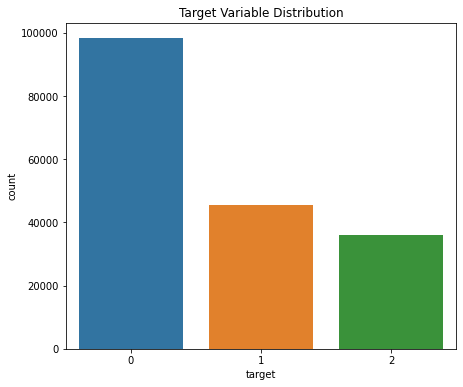

In [690]:
import seaborn as sns
plt.figure(figsize=(7, 6))
sns.countplot(train.target)
plt.title('Target Variable Distribution');

In [691]:
train.head()

,id,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,order_license_status,order_carrier_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,target,rider_id,active_rider_age,average_partner_rating,number_of_ratings,client_type_Business,client_type_Personal,vendor_type_Bike,year
0,ID_SCUW21PVAU,4435,27,6,2021-04-06 09:02:54,593630,0,2,30153,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,30153,11,10.00,1,1,0,1,2021
1,ID_2HA7X30JMN,32711,30,7,2021-04-06 13:01:37,837729,0,1,20884,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,2,20884,68,24.13,229,0,1,1,2021
2,ID_IAJWDTBY6M,8712,14,2,2021-04-06 10:01:00,695129,0,2,33143,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,1,33143,273,24.92,123,0,1,1,2021
3,ID_LKSVPNYMTR,44869,22,3,2021-04-06 14:11:16,1504660,0,2,96531,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,2,96531,168,23.76,175,0,1,1,2021
4,ID_O7N8Y918YH,57590,27,5,2021-04-06 16:11:38,36869,0,2,103546,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,0,103546,95,24.53,42,1,0,1,2021


In [692]:
train[['dispatch_day', 'dispatch_day_of_week', 'order_license_status',
       'order_carrier_type', 'rider_license_status', 'rider_carrier_type',
       'rider_amount', 'rider_lat', 'rider_long', 'pickup_lat', 'pickup_long',
       'drop_off_lat', 'drop_off_long', 'active_rider_age',
       'average_partner_rating']] = train[['dispatch_day', 'dispatch_day_of_week', 'order_license_status',
       'order_carrier_type', 'rider_license_status', 'rider_carrier_type',
       'rider_amount', 'rider_lat', 'rider_long', 'pickup_lat', 'pickup_long',
       'drop_off_lat', 'drop_off_long', 'active_rider_age',
       'average_partner_rating']].apply(pd.to_numeric)

In [693]:
# Split data
#main_cols = test.columns.difference(['id', 'order_id', 'rider_id', 'Rider ID', 'target', 'dispatch_time',	'client_id']).tolist()
X = train.drop(['client_type_Personal','client_type_Business','active_rider_age','id', 'order_id', 'rider_id', 'target', 'dispatch_time',	'client_id','vendor_type_Bike','year'],axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3031)


In [694]:
X_train.dtypes

dispatch_day                int64
dispatch_day_of_week        int64
order_license_status        int64
order_carrier_type          int64
rider_license_status        int64
rider_carrier_type          int64
rider_amount                int64
rider_lat                 float64
rider_long                float64
pickup_lat                float64
pickup_long               float64
drop_off_lat              float64
drop_off_long             float64
average_partner_rating    float64
number_of_ratings           int64
dtype: object

In [695]:
# Train a model
model = LGBMClassifier(random_state=3031)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check score
accuracy_score(y_test, y_pred)

0.6095791404903541

In [696]:
test.columns

Index(['id', 'order_id', 'dispatch_day', 'dispatch_day_of_week',
       'dispatch_time', 'client_id', 'order_license_status',
       'order_carrier_type', 'rider_id', 'rider_license_status',
       'rider_carrier_type', 'rider_amount', 'rider_lat', 'rider_long',
       'pickup_lat', 'pickup_long', 'drop_off_lat', 'drop_off_long',
       'rider_id', 'active_rider_age', 'average_partner_rating',
       'number_of_ratings', 'client_type_Business', 'client_type_Personal',
       'vendor_type_Bike', 'year'],
      dtype='object')

In [697]:
X

,dispatch_day,dispatch_day_of_week,order_license_status,order_carrier_type,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,average_partner_rating,number_of_ratings
0,27,6,0,2,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,10.00,1
1,30,7,0,1,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,24.13,229
2,14,2,0,2,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,24.92,123
3,22,3,0,2,1,1,510,-42.836266,-17.311920,-42.831913,-17.315311,-42.812409,-17.265441,23.76,175
4,27,5,0,2,0,0,400,-42.828195,-17.322818,-42.836056,-17.318111,-42.828517,-17.302052,24.53,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179862,9,4,0,2,0,1,530,-42.799022,-17.263385,-42.797847,-17.257129,-42.821718,-17.302860,10.24,20
179863,15,2,0,1,1,1,430,-42.824439,-17.273777,-42.821400,-17.272752,-42.786174,-17.281706,10.00,1
179864,13,7,1,2,1,1,490,-42.840226,-17.265304,-42.824923,-17.280676,-42.778648,-17.298742,24.91,116
179865,13,2,0,2,1,1,500,-42.817205,-17.338171,-42.836143,-17.317200,-42.790718,-17.258187,10.00,4


In [698]:
X.shape

(179867, 15)

In [699]:
test.head()

,id,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,order_license_status,order_carrier_type,rider_id,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_id,active_rider_age,average_partner_rating,number_of_ratings,client_type_Business,client_type_Personal,vendor_type_Bike,year
0,ID_3B4D2Q2DSI,28636,2,6,2021-04-06 12:10:59,593630,0,2,57224,1,1,450,-42.912776,-17.265738,-42.881861,-17.280865,-42.880476,-17.230240,57224,175,23.04,15,1,0,1,2021
1,ID_7MPWFJ9XFI,60465,11,4,2021-04-06 17:10:03,2378775,1,2,106329,1,1,560,-42.831932,-17.284140,-42.829545,-17.279453,-42.851920,-17.314558,106329,8,19.34,332,0,1,1,2021
2,ID_5VVT3Q3M5B,25249,30,3,2021-04-06 12:02:01,2121681,0,2,90551,0,0,450,-42.806437,-17.285166,-42.810915,-17.291086,-42.807165,-17.253860,90551,105,10.00,3,0,1,1,2021
3,ID_C2GTVS1H7K,21224,27,2,2021-04-06 11:10:32,38801,0,2,90482,1,1,440,-42.828448,-17.301909,-42.828517,-17.302052,-42.795516,-17.287921,90482,38,24.76,83,1,0,1,2021
4,ID_0YGC8V3PFT,58287,14,6,2021-04-06 16:12:55,153111,0,2,101959,1,1,500,-42.808912,-17.259955,-42.805154,-17.262939,-42.706475,-17.257454,101959,167,9.15,16,1,0,1,2021


In [700]:
test.shape

(76791, 26)

In [701]:
test = test.drop(['client_type_Personal','client_type_Business','active_rider_age','id', 'order_id',
                  'rider_id', 'rider_id','dispatch_time',	'client_id','vendor_type_Bike','year'], axis = 1)
test.shape

(76791, 15)

In [702]:
# Make predictions in test set and prepare submission file
predictions = model.predict(test)
sub_file = ss.copy()
sub_file.target = predictions
sub_file.to_csv('Baseline.csv', index = False)

### Export the tested model to a pickle file

To open the file for writing, simply use the open() function.

● The first argument should be the name of your file. 

● The second argument is 'wb'. 
The w means that you'll be writing to the file, and b refers to binary mode. 
This means that the data will be written in the form of byte objects. If 
you forget the b, a “TypeError: must be str, not bytes” will be returned. 
You may sometimes come across a slightly different notation; w+b, but 
don't worry, it provides the same functionality.

Once the file is opened for writing, you can use pickle.dump(), which 
takes two arguments: the object you want to pickle and the file to which 
the object has to be saved. In this case, the former will be our model - 
‘LR_Model’, while the latter will be ‘file’.



In [703]:
import pickle
with open('sendy_model.pickle','wb') as file:
    pickle.dump(model,file)

In [704]:
# pkl_filename = 'sendy_model.pkl'

# with open(pkl_filename, 'wb') as file:
#   pickle.dump(model, file)

### Importing the model back from file (Unpickling)

Use the open() function again, but this time with 'rb' as second argument (instead of 
wb). The r stands for read mode and the b stands for binary mode. You'll be reading 
a binary file. Assign this to ‘file’. Next, use pickle.load(), with ‘file’ as argument, and 
assign it to ‘Pickled_LR_Model’.

In [705]:
# with open(pkl_filename, 'rb') as file:
#   sendy_model = pickle.load(file)

# sendy_model

In [706]:
with open('sendy_model.pickle', 'rb') as file:
   sendy_model = pickle.load(file)

sendy_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3031, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Use the model to claculate accuracy scores and predict target values.

In [707]:
#Calculating score

score = sendy_model.score(X_test,y_test)
score

0.6095791404903541

### Compressing Pickle files.

This can be done using bzip2 or gzip. They both compress files, but 
bzip2 is a bit slower. gzip, however, produces files about twice as large as bzip2. 

Here, we are taking the example of a model called sendy_model that we wish to compress and store in a file named smallerfile.



In [708]:
import bz2

sfile = bz2.BZ2File('smallerfile','w')
pickle.dump(sendy_model, sfile)

PROs of Pickle :

1) Saving and restoring our learning models is quick - we can do it in two lines of 
code.

2) It is useful if you have optimized the model's parameters on the training data, so 
you don't need to repeat this step again.

CONs of Pickle :

1) It doesn't save the test results or any data.

2) Lambda functions can't be pickled. So if you try to apply it to a lambda function, it will fail. 

There is a solution for this. dill is a package similar to pickle that can serialize lambda 
functions, among other things. Its use is almost identical to pickle.


### 2. Joblib

The Joblib Module is available from Scikit Learn package and is intended to be a replacement for Pickle, for objects containing large data. It provides utilities for saving and loading Python objects that make use of NumPy data structures efficiently.

This approach will save our ML Model in the pickle format only but we don’t 
need to load additional libraries as the 'Pickling' facility is available within Scikit 
Learn package itself which we will use invariably for developing our ML models.


Saving model.

In [709]:
#import joblib module
from sklearn.externals import joblib

#save the model
joblib_file = 'joblib_sendy_model'
joblib.dump(sendy_model, joblib_file)

['joblib_sendy_model']

Reloading Model.

In [710]:
joblib_sendy_model = joblib.load(joblib_file)

In [711]:
#Using the reloaded file

#score = joblib_sendy_model(X_test, y_test)

PROs of Joblib :

1) The Joblib library offers a bit simpler workflow compared to Pickle.

2) While Pickle requires a file object to be passed as an argument, Joblib works with both file objects and string filenames.

3) In case our model contains large arrays of data, each array will be stored in a separate file, but the save and restore procedure will remain the same.

4) Joblib also allows different compression methods, such as 'zlib', 'gzip', 'bz2', and different levels of compression

### 3 Manual Save and Restore to JSON.

Whenever we want to have full control over the save and restore process, the best way is to build our own functions manually.

JSON stands for JavaScript Object Notation. It's a lightweight format for data-interchange, that is easily readable by humans. 

The text in JSON is done through quoted-string which contains value in key-value mapping within { }. It is similar to the dictionary in Python. 

### Saving and loading a Deep Learning Model.

A Keras model consists of multiple components:

1. An architecture, or configuration, which specifies what 
layers the model contain, and how they're connected.

2. A set of weights values (the "state of the model").

3. An optimizer (defined by compiling the model).

4. A set of losses and metrics (defined by compiling the 
model or calling add_loss() or add_metric())

The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

1. Saving everything into a single archive in the TensorFlow 
SavedModel format (or in the older Keras H5 format). This is the standard practice.

2. Saving the architecture / configuration only, typically as a JSON file.

3. Saving the weights values only. This is generally used when training the model.


Saving model.

In [712]:
# model = ...  # Get model (Sequential, Functional Model, or Model subclass)
# model.save('path/to/location')

Loading the model back.

In [713]:
# from tensorflow import keras
# model = keras.models.load_model('path/to/location')